В этом notebook мы будем работать над улучшением метрик бейслайн моделей, путем дополнительных преобразований с данными. Существует 2 подхода:

1. Тестировать каждое преобразование отдельно и сравнивать с бейслайном, затем выбрать только лучшие и скомбинировать их
2. Поочередно применять удачные преобразования, сравнивая результат каждого нового преобразования с результатом предыдущего (итеративный подход)

Здесь мы будем использовать первый подход

## 1. Предобработка
Выполняем все те же операции, что и в бейслайне

In [1]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, TargetEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from lightgbm import LGBMClassifier
from helper import *
from plots import *
import random

In [8]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

In [9]:
df = pd.read_csv("data.csv")

## 1. Предобработка

In [10]:
# Общие преобразования
df_preprocessed = df.copy()
df_preprocessed = df_preprocessed.drop(columns=['Loan_ID'])
df_preprocessed['Credit_History'] = df_preprocessed['Credit_History'].fillna(2)
df_preprocessed['Dependents'] = np.where(df_preprocessed['Dependents'] == '3+', 3, df_preprocessed['Dependents'])
df_preprocessed['Dependents'] = pd.to_numeric(df_preprocessed['Dependents'])
df_preprocessed['Loan_Status'] = np.where(df_preprocessed['Loan_Status'] == 'Y', 1, 0)
df_preprocessed['Loan_Amount_Term'] = pd.to_numeric(df_preprocessed['Loan_Amount_Term'])

In [11]:
X, y = divide_data(df_preprocessed, 'Loan_Status')

In [12]:
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
numeric_cols = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
most_frequent_numeric_cols = ['Dependents', 'Loan_Amount_Term']
most_frequent_cat_cols = ['Gender', 'Married', 'Self_Employed']
mean_imputer_cols = ['LoanAmount']
category_orders = [
    ['Male', 'Female'], # gender
    ['No', 'Yes'], # married                         
    ['Not Graduate', 'Graduate'], # education    
    ['No', 'Yes'], # self employed
    ['Rural', 'Semiurban', 'Urban'] # property area        
]

# уже знакомый нам пайплайн
preprocessor = Pipeline([
    ('nan_remover', ColumnTransformer(
        [
            ('most_frequent_numeric', SimpleImputer(strategy='most_frequent'), most_frequent_numeric_cols),
            ('most_frequent_cat', SimpleImputer(strategy='most_frequent'), most_frequent_cat_cols),
            ('mean', SimpleImputer(strategy='mean'), mean_imputer_cols)
        ],
        remainder='passthrough', 
        verbose_feature_names_out=False
    )),
    
    ('transformations', ColumnTransformer(
        [('encoder', OrdinalEncoder(categories=category_orders), categorical_cols)],
        remainder='passthrough',
        verbose_feature_names_out=False
    ))
])
preprocessor.set_output(transform="pandas")

Pipeline(steps=[('nan_remover',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('most_frequent_numeric',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Dependents',
                                                   'Loan_Amount_Term']),
                                                 ('most_frequent_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Gender', 'Married',
                                                   'Self_Employed']),
                                                 ('mean', SimpleImputer(),
                                                  ['LoanAmount'])],
                                   verbose_feature_names_out=False)),
                ('transformations',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OrdinalEncoder(categories=[['Male',
                                                                              'Female'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Not '
                                                                              'Graduate',
                                                                              'Graduate'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Rural',
                                                                              'Semiurban',
                                                                              'Urban']]),
                                                  ['Gender', 'Married',
                                                   'Education', 'Self_Employed',
                                                   'Property_Area'])],
                                   verbose_feature_names_out=False))])

In [13]:
# сохраним все бейслайн модели в виде списка для удобства
models = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED))
]

In [ ]:
# используем 5-блочную кросс-валидацию, учитывающую распределение таргета при разбиении
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<Figure size 1500x600 with 0 Axes>

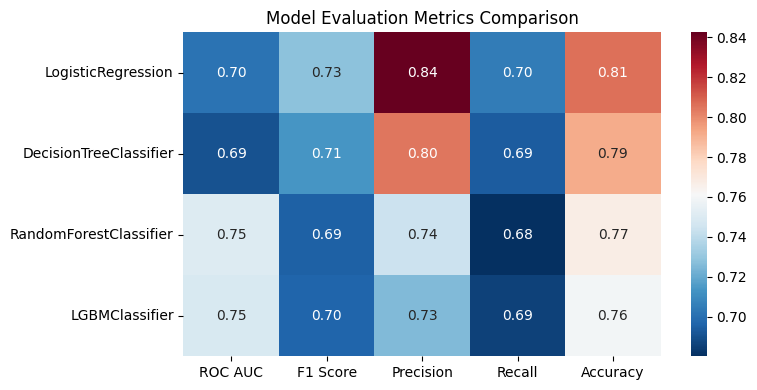

In [17]:
initial_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

## 2. Преобразования данных и feature engineering

### 2.1 Логарифмическое преобразование
В нашем датасете имеются "денежные" признаки ApplicantIncome, CoapplicantIncome, LoanAmount, которые имеют асимметричное распределение. Логарифмирование позволит сделать их более нормальными

#### 2.1.1 Без удаления столбцов

In [18]:
X_log = X.copy()

In [19]:
X_log['ApplicantIncomeLog'] = np.log1p(X_log['ApplicantIncome'])
X_log['CoapplicantIncomeLog'] = np.log1p(X_log['CoapplicantIncome'])
X_log['LoanAmountLog'] = np.log1p(X_log['LoanAmount'])

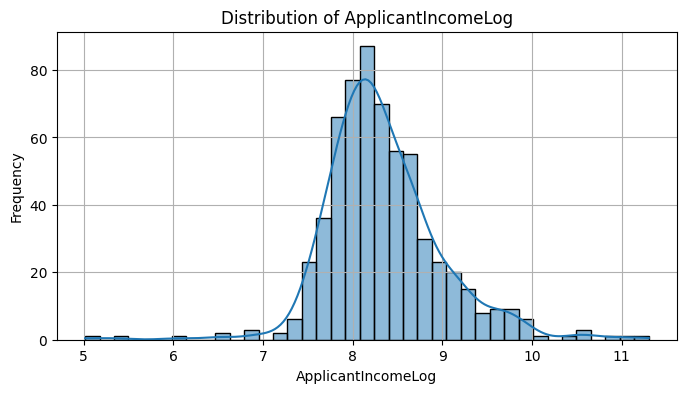

In [20]:
plot_hist_numeric(X_log, 'ApplicantIncomeLog')

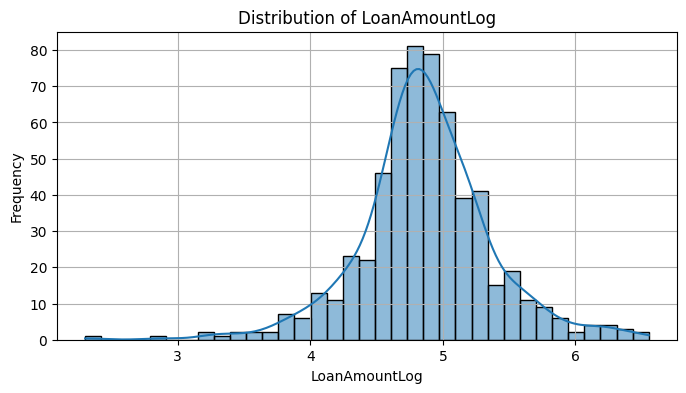

In [21]:
plot_hist_numeric(X_log, 'LoanAmountLog')

В результате логарифмирования наши распределения стали ближе к нормальным

In [22]:
#добавим новую колонку в препроцессор, чтобы пропуски в ней также заполнились
preprocessor_log = clone(preprocessor)
preprocessor_log['nan_remover'].transformers[2][2].append('LoanAmountLog')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

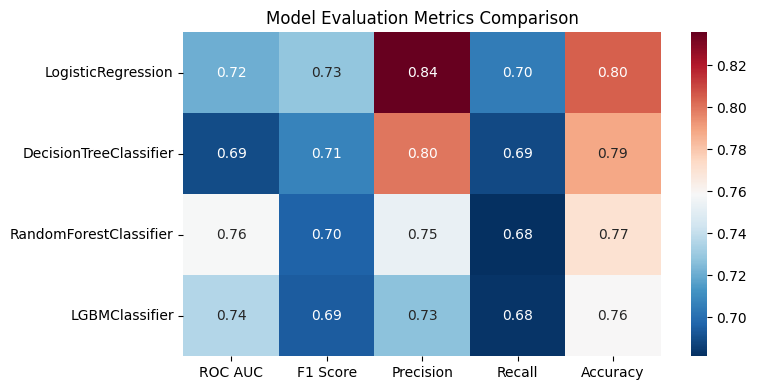

In [23]:
log_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log,
    y=y,
    preprocessor=preprocessor_log,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.019548 -0.000302  -0.006767  0.000211 -0.001626
 DecisionTreeClassifier -0.000946 -0.006303  -0.004529 -0.005128 -0.003252
 RandomForestClassifier  0.008191  0.001465   0.008565  0.001089  0.003252
 LGBMClassifier         -0.012698 -0.002186   0.001239 -0.002857  0.000013)

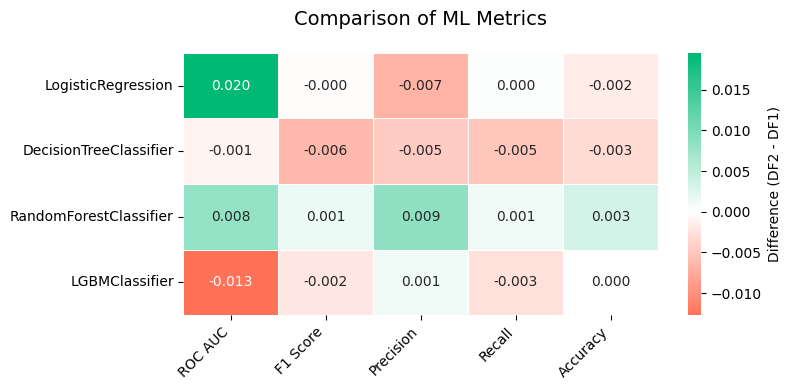

In [24]:
# сравним изначальные метрики с метриками после логарифмирования и выведем график
compare_metrics_heatmap(initial_metrics, log_metrics)

Наблюдаем незначительные колебания метрик, весомого улучшения нет

#### 2.1.2 С удалением исходных столбцов

In [25]:
X_log_delete = X.copy()

In [26]:
X_log_delete['ApplicantIncome'] = np.log1p(X_log_delete['ApplicantIncome'])
X_log_delete['CoapplicantIncome'] = np.log1p(X_log_delete['CoapplicantIncome'])
X_log_delete['LoanAmount'] = np.log1p(X_log_delete['LoanAmount'])

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

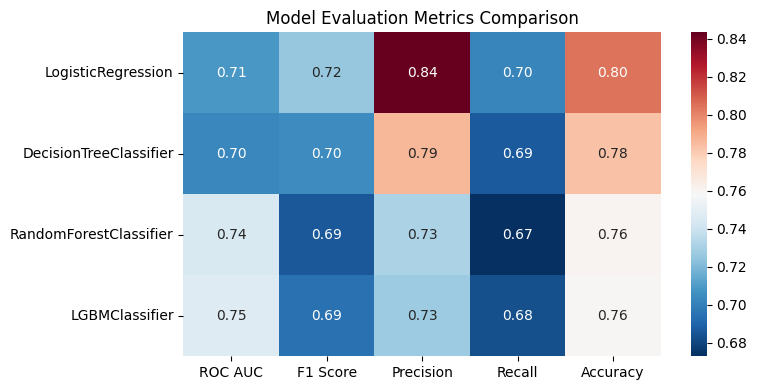

In [27]:
log_delete_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log_delete,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.007134 -0.003346   0.001092 -0.002536 -0.001613
 DecisionTreeClassifier  0.011989 -0.009215  -0.018355 -0.007259 -0.008130
 RandomForestClassifier -0.005427 -0.008783  -0.012836 -0.007439 -0.006491
 LGBMClassifier         -0.001158 -0.002345   0.001388 -0.002924  0.000027)

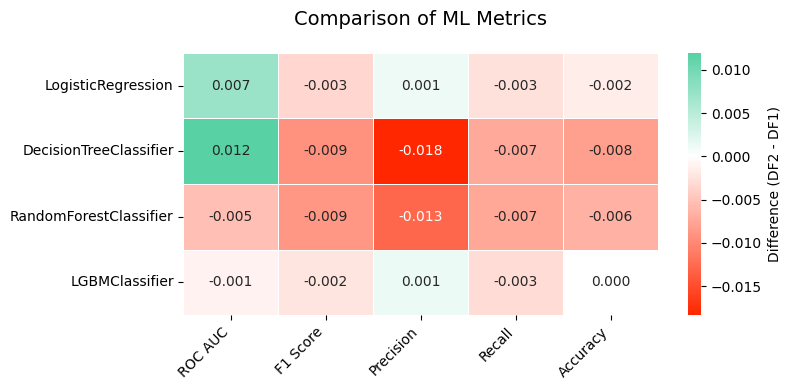

In [28]:
compare_metrics_heatmap(initial_metrics, log_delete_metrics)

C удалением столбцов преобразование работает хуже

### 2.2 Создание нового признака "TotalIncome"
Возможно, сумма доходов будет лучше влиять на предсказание, чем доход каждого в отдельности

In [29]:
X_total_income = X.copy()

In [30]:
X_total_income['TotalIncome'] = X_total_income['ApplicantIncome'] + X_total_income['CoapplicantIncome']
X_total_income = X_total_income.drop(columns=['ApplicantIncome', 'CoapplicantIncome'])

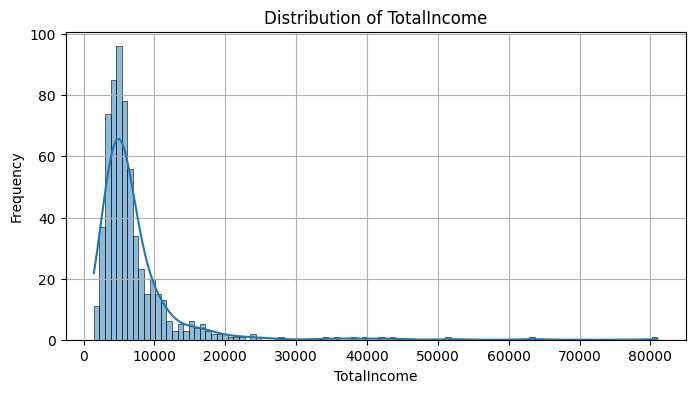

In [31]:
plot_hist_numeric(X_total_income, 'TotalIncome')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

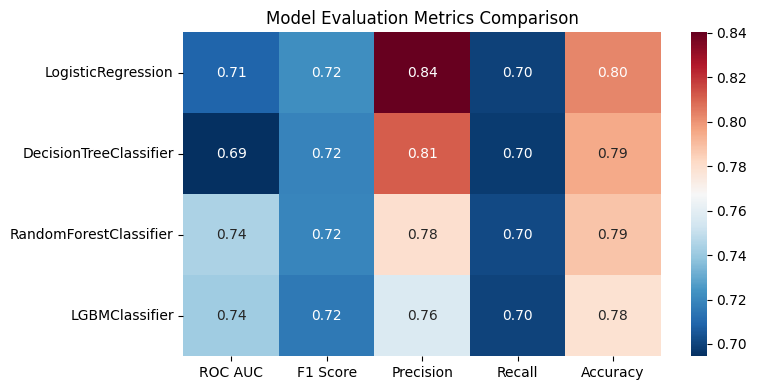

In [32]:
total_income_metrics = train_evaluate_models_cv(
    models=models,
    X=X_total_income,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.007516 -0.005852  -0.002143 -0.005210 -0.003252
 DecisionTreeClassifier  0.003823  0.005001   0.007147  0.003592  0.003225
 RandomForestClassifier -0.006007  0.024184   0.035465  0.021159  0.021152
 LGBMClassifier         -0.007009  0.018406   0.031271  0.014106  0.019605)

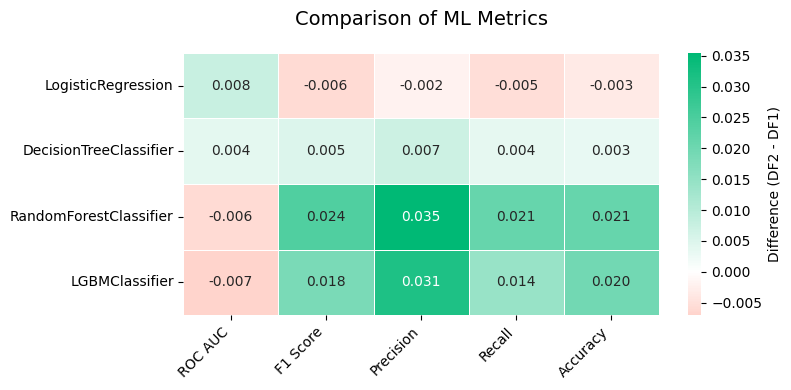

In [33]:
compare_metrics_heatmap(initial_metrics, total_income_metrics)

Наблюдаем улучшение всех метрик для случайного леса и бустинга, кроме рок аук

### 2.3 Отношение кредита к доходу (Loan-to-Income Ratio, LIR)

In [34]:
X_lir = X.copy()

In [35]:
X_lir['LIR'] = X_lir['LoanAmount'] / (X_lir['ApplicantIncome'] + X_lir['CoapplicantIncome'])

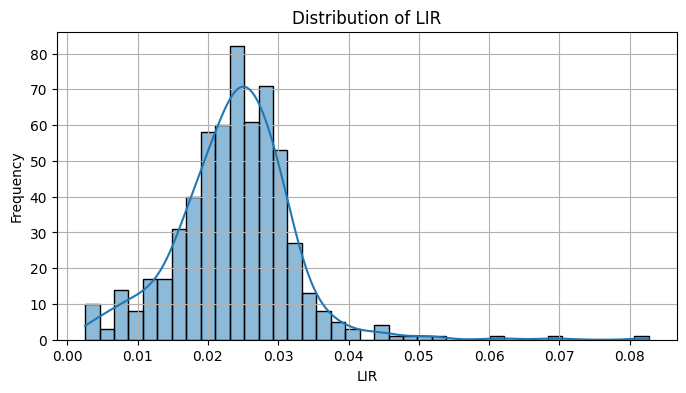

In [36]:
plot_hist_numeric(X_lir, 'LIR')

In [37]:
preprocessor_lir = clone(preprocessor)
preprocessor_lir['nan_remover'].transformers[2][2].append('LIR')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

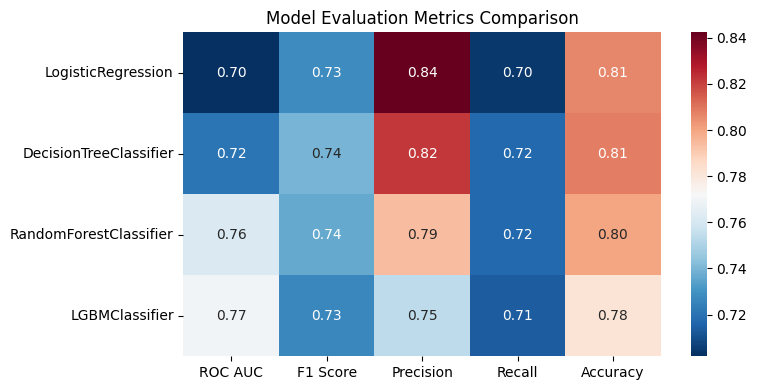

In [38]:
lir_metrics = train_evaluate_models_cv(
    models=models,
    X=X_lir,
    y=y,
    preprocessor=preprocessor_lir,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.000426  0.000000   0.000000  0.000000  0.000000
 DecisionTreeClassifier  0.030159  0.026184   0.017373  0.023189  0.016287
 RandomForestClassifier  0.011527  0.041287   0.049817  0.036524  0.032600
 LGBMClassifier          0.021230  0.029678   0.028276  0.027816  0.022898)

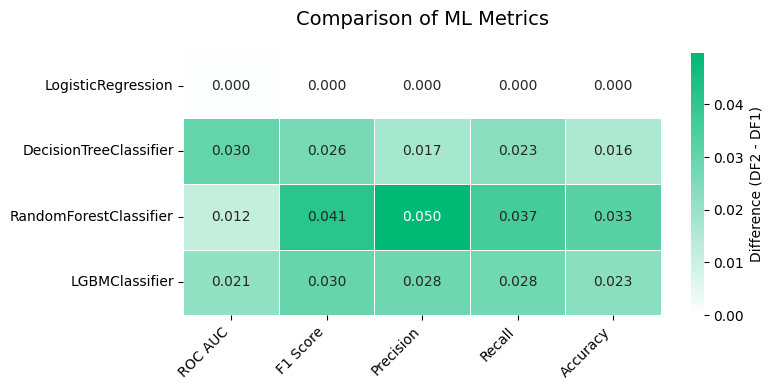

In [39]:
compare_metrics_heatmap(initial_metrics, lir_metrics)

Введение этой фичи положительно сказалось на метриках. Хоть в некоторых случаях значение precision стало меньше, это компенсировалось увеличением recall и итоговые метрики выросли

### 2.4 Биннинг для Loan_Amount_Term
Как мы убедились ранее, этот признак по сути категориальный, поэтому имеет смысл сделать биннинг и порядковое кодирование

#### 2.4.1 Без удаления

In [40]:
X_loan_amount_term_binning = X.copy()

In [41]:
bins = [-np.inf, 180, 360, np.inf]
labels = [0, 1, 2]

X_loan_amount_term_binning['Loan_Amount_Term_bins'] = pd.cut(X_loan_amount_term_binning['Loan_Amount_Term'], bins=bins, labels=labels)

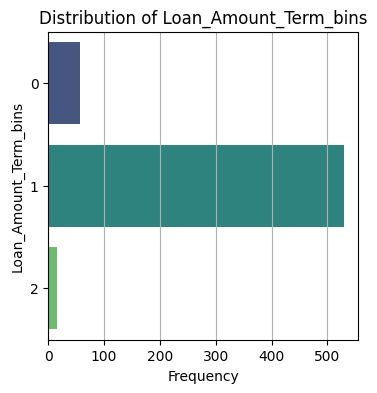

In [42]:
plot_hist_categorical(X_loan_amount_term_binning, 'Loan_Amount_Term_bins')

In [43]:
preprocessor_loan_amount_term_binning = clone(preprocessor)
preprocessor_loan_amount_term_binning['nan_remover'].transformers[0][2].append('Loan_Amount_Term_bins')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

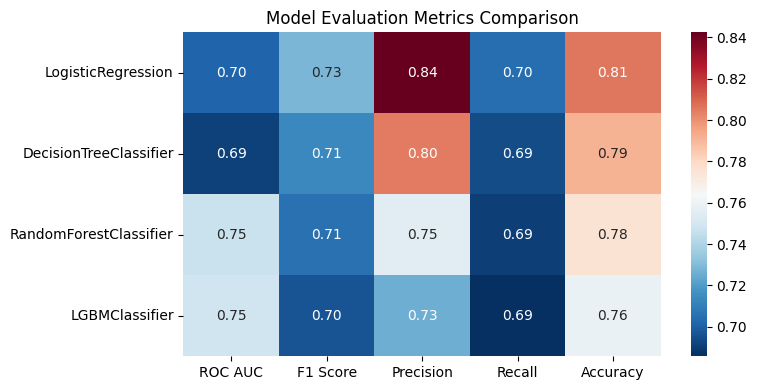

In [45]:
loan_amount_term_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=X_loan_amount_term_binning,
    y=y,
    preprocessor=preprocessor_loan_amount_term_binning,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision   Recall  Accuracy
 LogisticRegression      0.000124  0.000000   0.000000  0.00000  0.000000
 DecisionTreeClassifier  0.000372  0.000000   0.000000  0.00000  0.000000
 RandomForestClassifier -0.003227  0.010917   0.010901  0.01029  0.008143
 LGBMClassifier          0.000000  0.000000   0.000000  0.00000  0.000000)

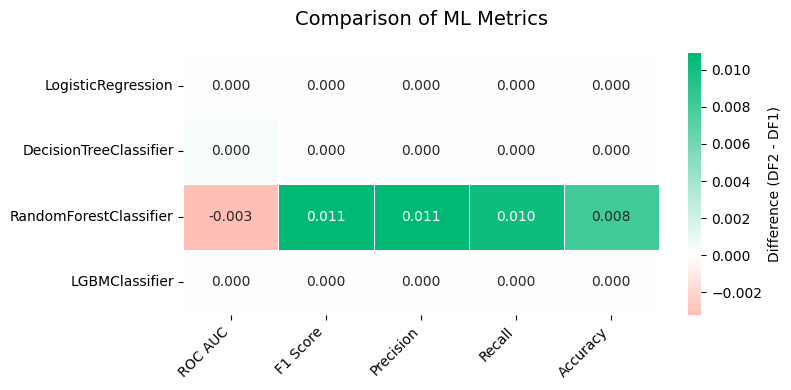

In [46]:
compare_metrics_heatmap(initial_metrics, loan_amount_term_binning_metrics)

Улучшения практически не наблюдается

#### 2.4.2 С удалением

In [47]:
X_loan_amount_term_binning_del = X.copy()

In [48]:
bins = [-np.inf, 180, 360, np.inf]
labels = [0, 1, 2]

X_loan_amount_term_binning_del['Loan_Amount_Term'] = pd.cut(X_loan_amount_term_binning_del['Loan_Amount_Term'], bins=bins, labels=labels)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<Figure size 1500x600 with 0 Axes>

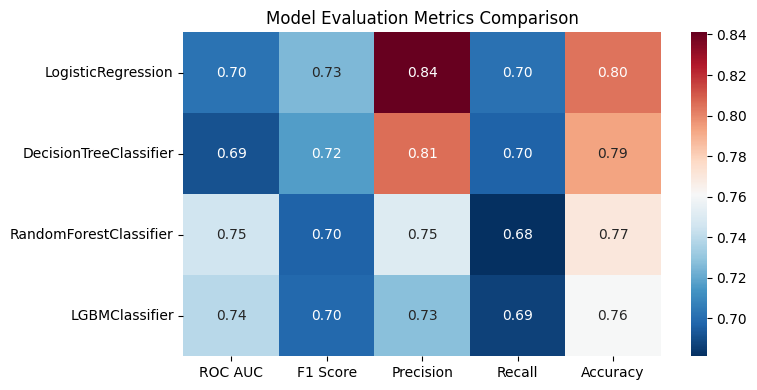

In [49]:
loan_amount_term_binning_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_loan_amount_term_binning_del,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.000523 -0.002969  -0.001345 -0.002632 -0.001626
 DecisionTreeClassifier  0.001022  0.002942   0.001555  0.002632  0.001626
 RandomForestClassifier -0.005097  0.001640   0.005961  0.001021  0.003279
 LGBMClassifier         -0.009233  0.001519   0.002272  0.001081  0.001639)

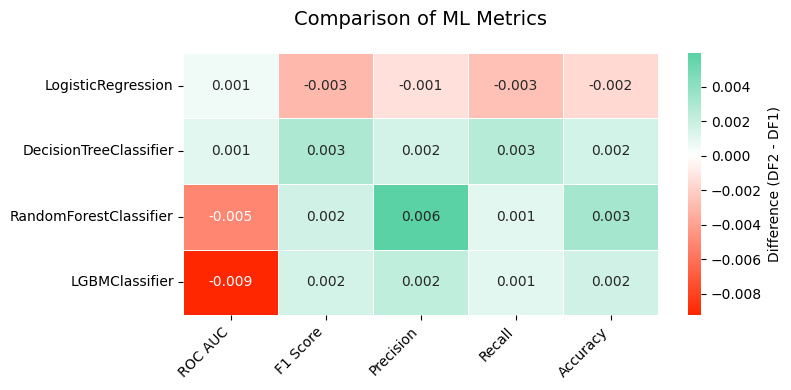

In [50]:
compare_metrics_heatmap(initial_metrics, loan_amount_term_binning_metrics_del)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.000398 -0.002969  -0.001345 -0.002632 -0.001626
 DecisionTreeClassifier  0.000650  0.002942   0.001555  0.002632  0.001626
 RandomForestClassifier -0.001870 -0.009277  -0.004940 -0.009268 -0.004865
 LGBMClassifier         -0.009233  0.001519   0.002272  0.001081  0.001639)

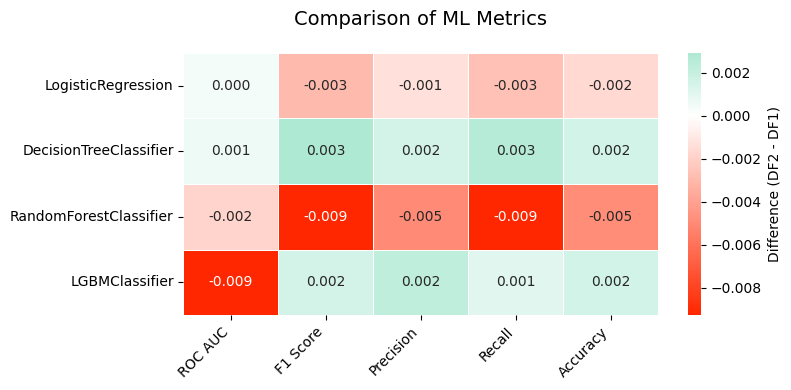

In [51]:
compare_metrics_heatmap(loan_amount_term_binning_metrics, loan_amount_term_binning_metrics_del)

Опять же, улучшения нет

### 2.5 Применение StandardScaler (стандартизация)

#### 2.5.1 Без удаления

In [52]:
X_standard_scaler = X.copy()

In [53]:
scaled_columns = ['ApplicantIncomeScaled', 'CoapplicantIncomeScaled', 'LoanAmountScaled']
X_standard_scaler[scaled_columns] = X_standard_scaler[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]

In [54]:
preprocessor_standard_scaler = clone(preprocessor)

preprocessor_standard_scaler['transformations'].transformers.append(
    ('scaler', StandardScaler(), scaled_columns)
)

preprocessor_standard_scaler['nan_remover'].transformers[0][2].extend(scaled_columns)

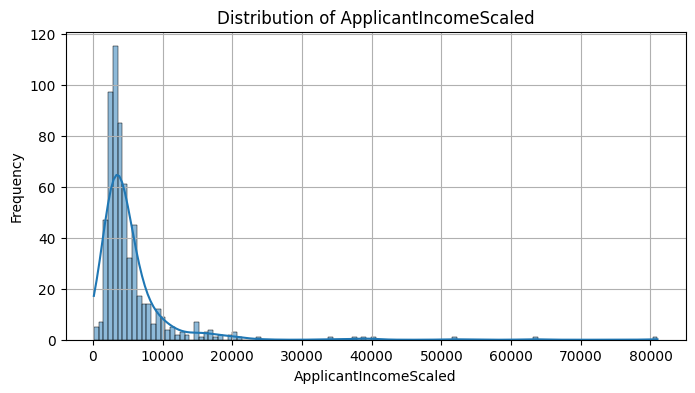

In [55]:
plot_hist_numeric(X_standard_scaler, 'ApplicantIncomeScaled')

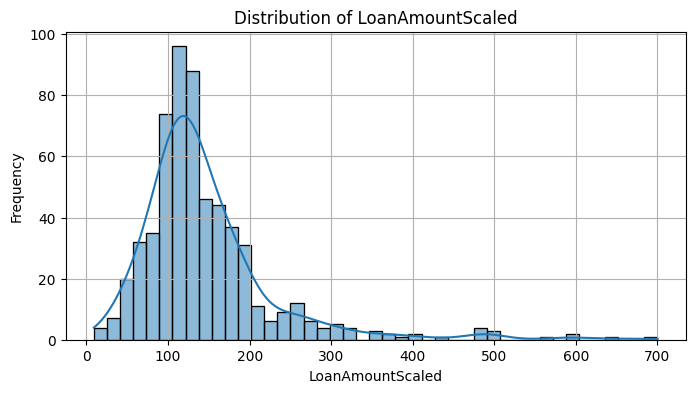

In [56]:
plot_hist_numeric(X_standard_scaler, 'LoanAmountScaled')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

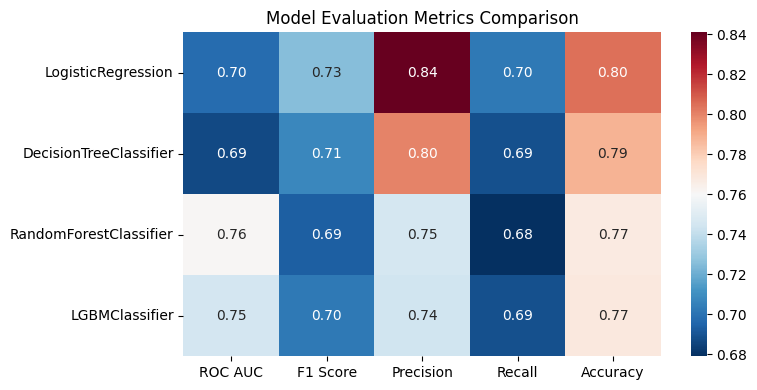

In [57]:
standard_scaler_metrics = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler,
    y=y,
    preprocessor=preprocessor_standard_scaler,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.003990 -0.002969  -0.001345 -0.002632 -0.001626
 DecisionTreeClassifier -0.003534 -0.006303  -0.004529 -0.005128 -0.003252
 RandomForestClassifier  0.010654 -0.001394   0.001580 -0.001278  0.000013
 LGBMClassifier         -0.003217  0.005618   0.018364  0.002831  0.009796)

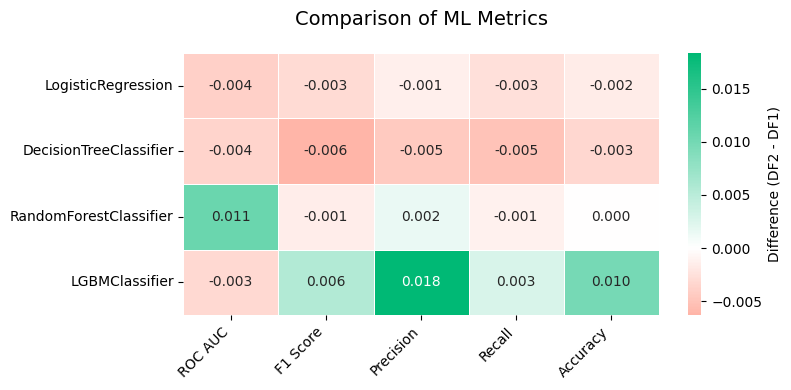

In [58]:
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics)

Улучшился только ROC AUC для случайного леса, в остальном незначительные ухудшения

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.023538 -0.002667   0.005422 -0.002843  0.000000
 DecisionTreeClassifier -0.002588  0.000000   0.000000  0.000000  0.000000
 RandomForestClassifier  0.002463 -0.002859  -0.006985 -0.002367 -0.003239
 LGBMClassifier          0.009481  0.007804   0.017125  0.005688  0.009783)

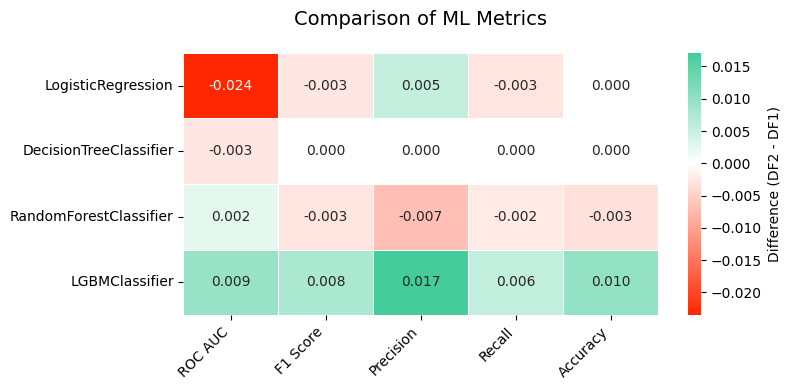

In [59]:
compare_metrics_heatmap(log_metrics, standard_scaler_metrics)

#### 2.5.2 С удалением

In [60]:
X_standard_scaler_del = X.copy()

In [61]:
preprocessor_standard_scaler_del = clone(preprocessor)

preprocessor_standard_scaler_del['transformations'].transformers.append(
    ('scaler', StandardScaler(), ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'])
)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

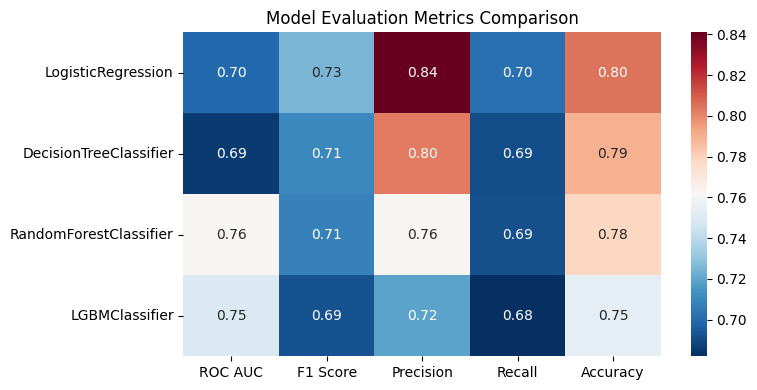

In [62]:
standard_scaler_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler_del,
    y=y,
    preprocessor=preprocessor_standard_scaler_del,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.002417 -0.002969  -0.001345 -0.002632 -0.001626
 DecisionTreeClassifier -0.005075 -0.002867  -0.001501 -0.002632 -0.001639
 RandomForestClassifier  0.012151  0.012966   0.019049  0.011216  0.011422
 LGBMClassifier          0.000951 -0.004245  -0.006841 -0.003734 -0.004878)

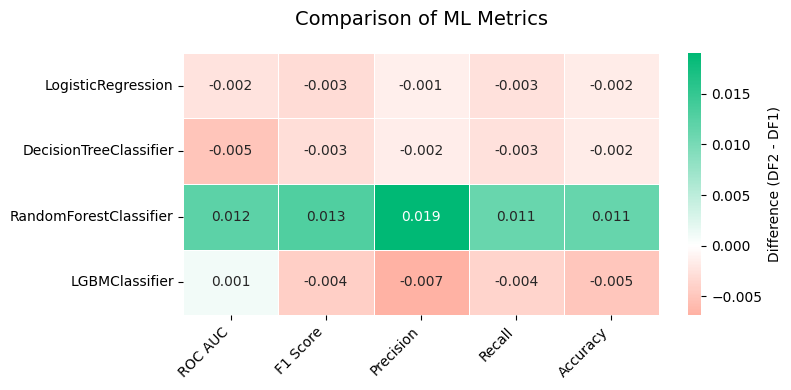

In [63]:
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics_del)

Улучшило только случайный лес

### 2.6 Нормализация

#### 2.6.1 Без удаления

In [64]:
X_normalised = X.copy()

In [65]:
scaled_columns = ['ApplicantIncomeScaled', 'CoapplicantIncomeScaled', 'LoanAmountScaled']
X_normalised[scaled_columns] = X_normalised[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]

In [66]:
preprocessor_normalisation = clone(preprocessor)

preprocessor_normalisation['transformations'].transformers.append(
    ('scaler', MinMaxScaler(), scaled_columns)
)

preprocessor_normalisation['nan_remover'].transformers[0][2].extend(scaled_columns)

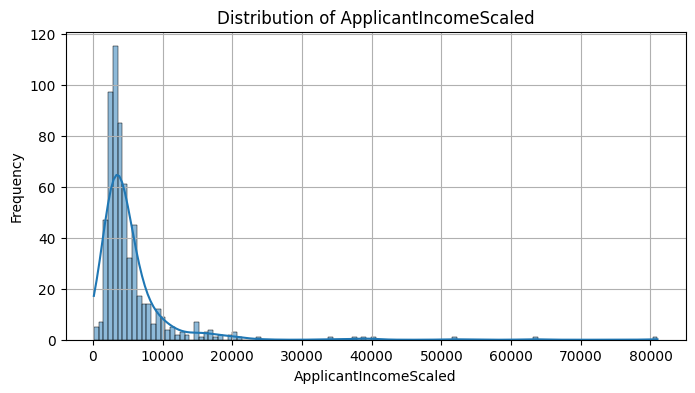

In [67]:
plot_hist_numeric(X_normalised, 'ApplicantIncomeScaled')

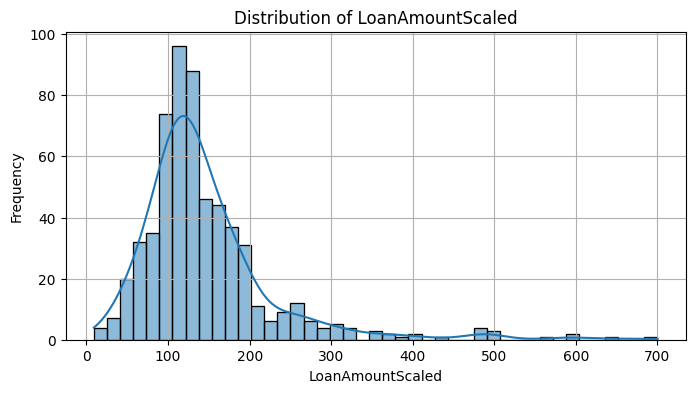

In [68]:
plot_hist_numeric(X_normalised, 'LoanAmountScaled')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

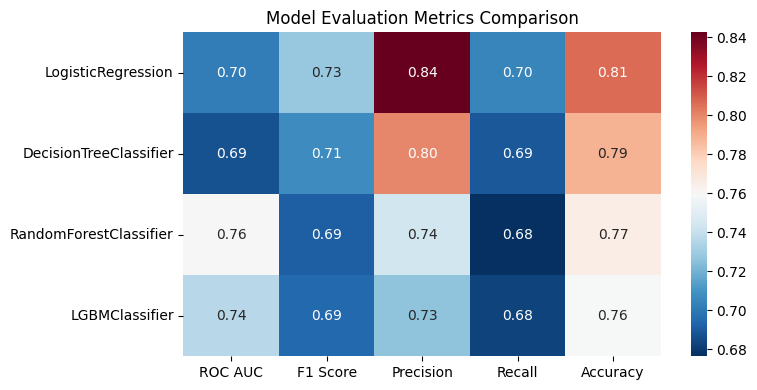

In [69]:
normalised_metrics = train_evaluate_models_cv(
    models=models,
    X=X_normalised,
    y=y,
    preprocessor=preprocessor_normalisation,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.000061  0.000000   0.000000  0.000000  0.000000
 DecisionTreeClassifier -0.003534 -0.006303  -0.004529 -0.005128 -0.003252
 RandomForestClassifier  0.009645 -0.004077  -0.000393 -0.003910 -0.001626
 LGBMClassifier         -0.011756 -0.002428   0.000330 -0.002964  0.000027)

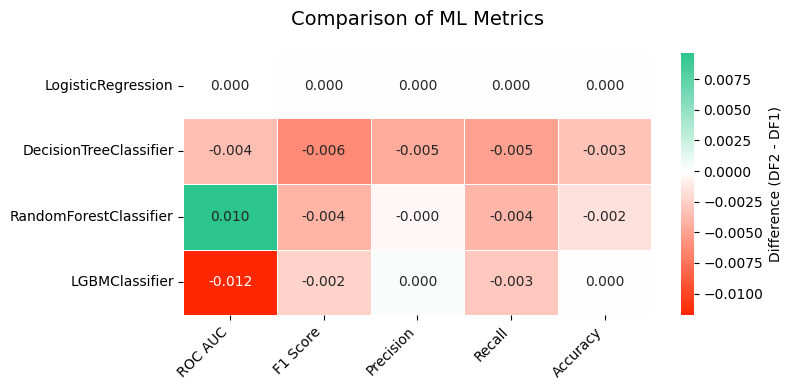

In [70]:
compare_metrics_heatmap(initial_metrics, normalised_metrics)

В основном только ухудшение метрик

#### 2.6.2 С удалением

In [72]:
X_normalised_del = X.copy()

In [73]:
preprocessor_normalisation_del = clone(preprocessor)

preprocessor_normalisation_del['transformations'].transformers.append(
    ('scaler', MinMaxScaler(), ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'])
)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

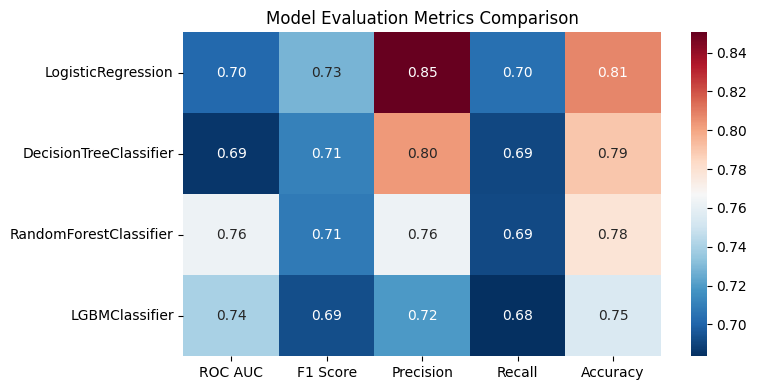

In [74]:
normalised_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_normalised_del,
    y=y,
    preprocessor=preprocessor_normalisation_del,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.000150  0.000009   0.008046 -0.000197  0.001639
 DecisionTreeClassifier -0.005075 -0.002867  -0.001501 -0.002632 -0.001639
 RandomForestClassifier  0.012468  0.012966   0.019049  0.011216  0.011422
 LGBMClassifier         -0.008619 -0.003549  -0.006741 -0.002144 -0.004891)

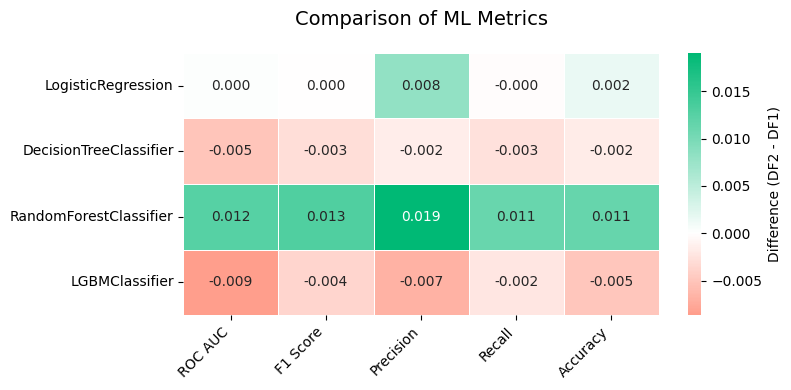

In [75]:
compare_metrics_heatmap(initial_metrics, normalised_metrics_del)

### 2.7 Обработка выбросов

In [76]:
X_no_outliers = X.copy()

In [77]:
X_no_outliers = winsorize_outliers(X_no_outliers, 'ApplicantIncome', upper_bound=25000)
X_no_outliers = winsorize_outliers(X_no_outliers, 'CoapplicantIncome', upper_bound=10000)
X_no_outliers = winsorize_outliers(X_no_outliers, 'LoanAmount', upper_bound=500)

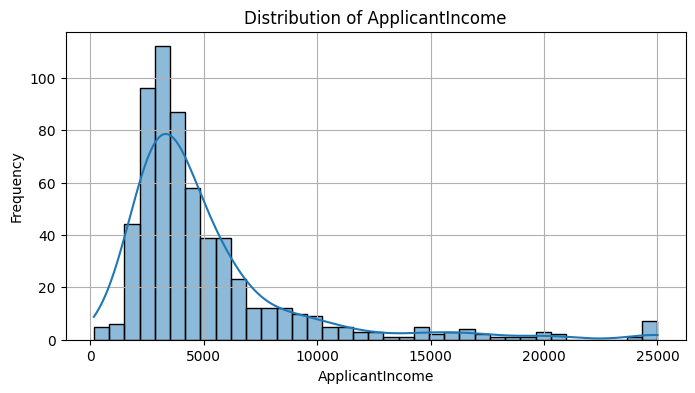

In [78]:
plot_hist_numeric(X_no_outliers, 'ApplicantIncome')

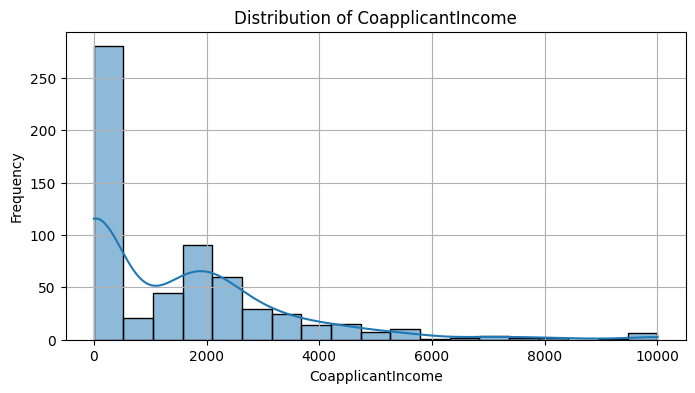

In [79]:
plot_hist_numeric(X_no_outliers, 'CoapplicantIncome')

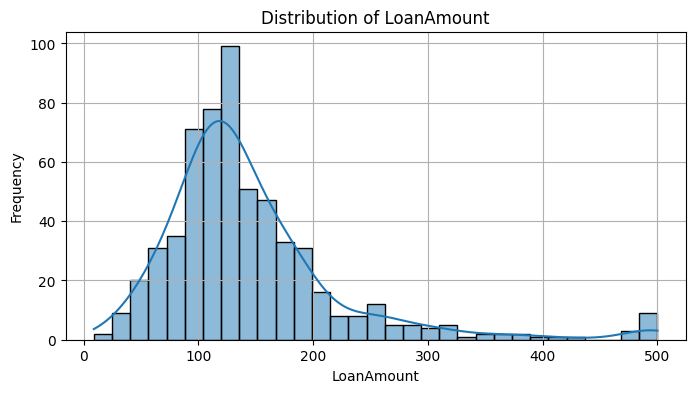

In [80]:
plot_hist_numeric(X_no_outliers, 'LoanAmount')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

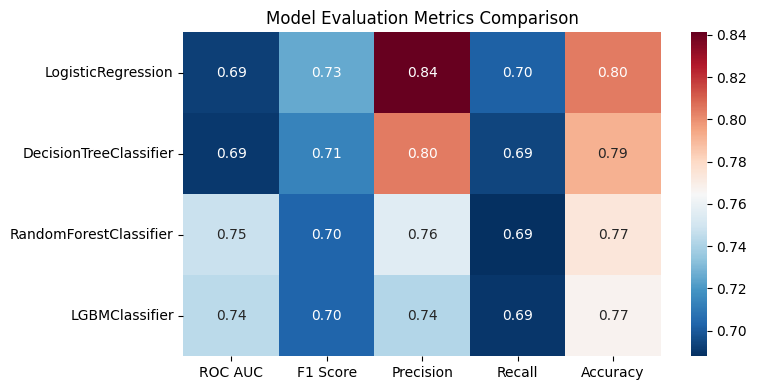

In [81]:
no_outliers_metrics = train_evaluate_models_cv(
    models=models,
    X=X_no_outliers,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.009159 -0.003125  -0.001229 -0.002564 -0.001613
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000  0.000000
 RandomForestClassifier -0.002677  0.008406   0.011093  0.007630  0.006504
 LGBMClassifier         -0.004206  0.006301   0.016147  0.004430  0.008157)

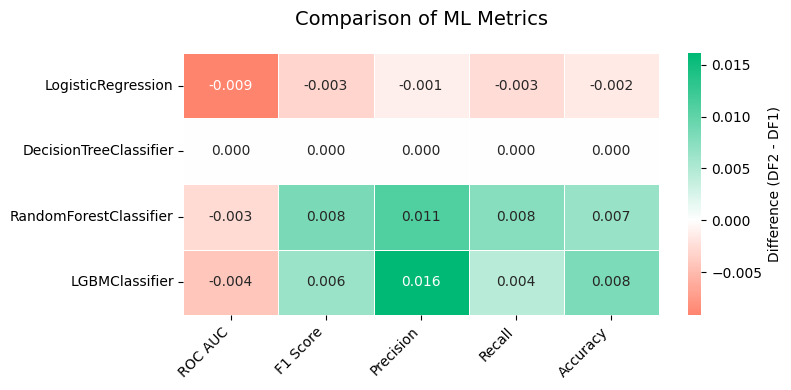

In [82]:
compare_metrics_heatmap(initial_metrics, no_outliers_metrics)

Ощутимых улучшений не наблюдается

### 2.9 Таргетное кодирование

In [83]:
preprocessor_target_encoding = clone(preprocessor)
preprocessor_target_encoding['transformations'].transformers[0] = ('encoder', TargetEncoder(categories=category_orders), categorical_cols)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

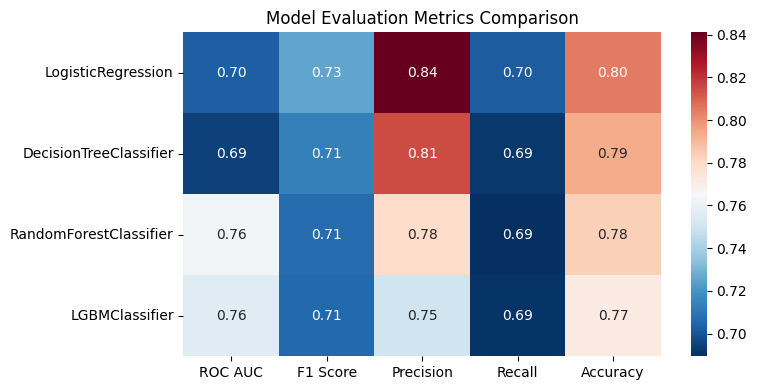

In [84]:
target_encoder_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor_target_encoding,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.001434 -0.002969  -0.001345 -0.002632 -0.001626
 DecisionTreeClassifier  0.003861 -0.000266   0.009910 -0.001776  0.001626
 RandomForestClassifier  0.012605  0.012112   0.035766  0.009104  0.016287
 LGBMClassifier          0.008011  0.009149   0.024213  0.005198  0.013048)

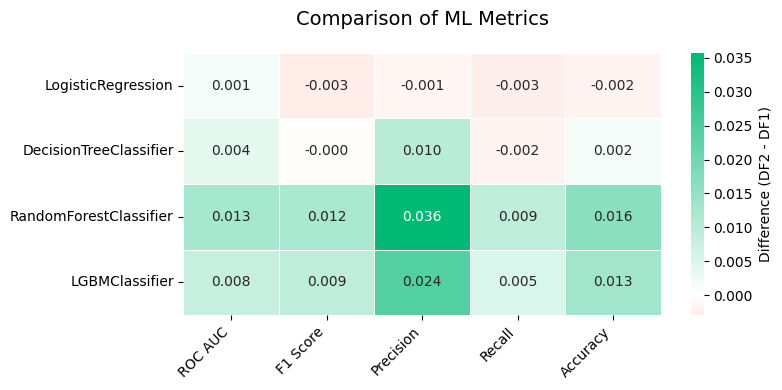

In [85]:
compare_metrics_heatmap(initial_metrics, target_encoder_metrics)

Заметно небольшое улучшение

### 2.10 Работа с дисбалансом классов

#### 2.10.1 На уровне моделей

In [86]:
models_balanced = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear', class_weight='balanced')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4, class_weight='balanced')),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED, class_weight='balanced'))
]

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

<Figure size 1500x600 with 0 Axes>

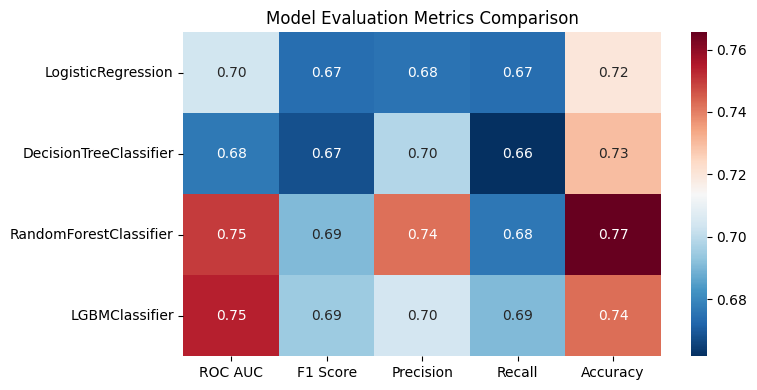

In [87]:
balanced_metrics = train_evaluate_models_cv(
    models=models_balanced,
    X=X,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.002305 -0.054028  -0.167213 -0.030297 -0.086379
 DecisionTreeClassifier -0.014033 -0.045372  -0.106033 -0.032134 -0.061842
 RandomForestClassifier -0.000195 -0.004003  -0.001874 -0.003991 -0.001599
 LGBMClassifier          0.005471 -0.002008  -0.021587  0.005135 -0.016287)

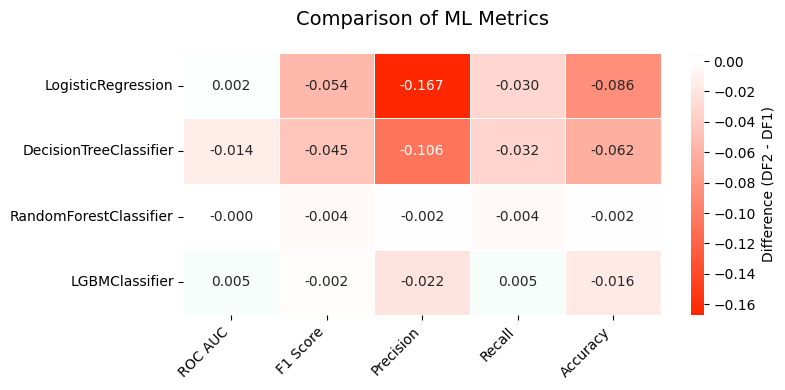

In [88]:
compare_metrics_heatmap(initial_metrics, balanced_metrics)

#### 2.10.2 Используя SMOTE

In [89]:
preprocessor_smote = clone(preprocessor)

preprocessor_smote.steps.append(
    ('smote', SMOTE(random_state=SEED))
)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

<Figure size 1500x600 with 0 Axes>

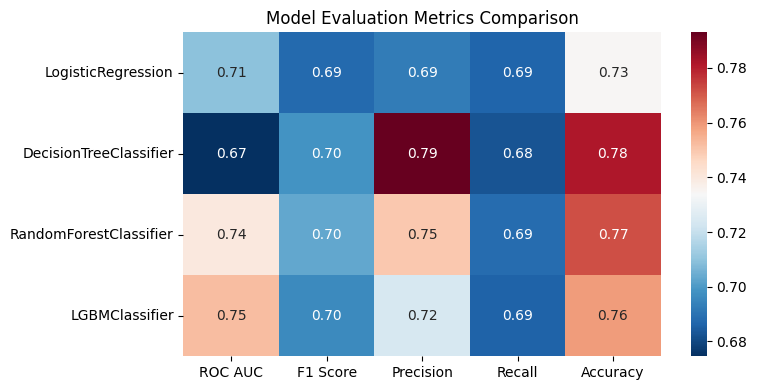

In [90]:
smote_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor_smote,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.007826 -0.040259  -0.149855 -0.018184 -0.071731
 DecisionTreeClassifier -0.016075 -0.014835  -0.011500 -0.011112 -0.009716
 RandomForestClassifier -0.009936  0.008307   0.005493  0.007895  0.004931
 LGBMClassifier          0.003648 -0.000407  -0.001900 -0.000028  0.000067)

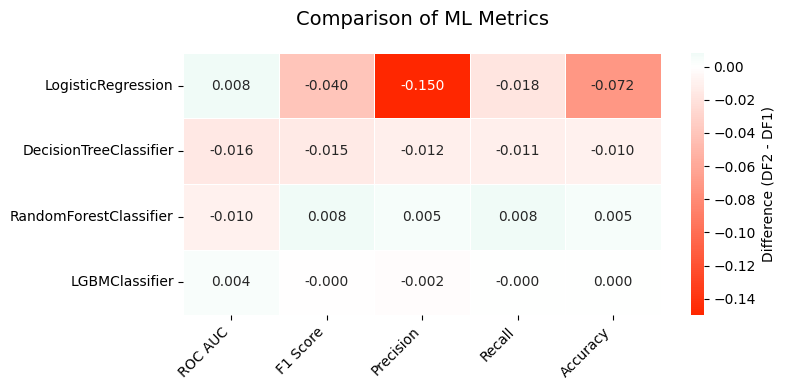

In [91]:
compare_metrics_heatmap(initial_metrics, smote_metrics)

### 2.11 Итоговый результат

Из всех преобразований только введение доп. фичи loan to income ratio дало ощутимое улучшение, его мы и применим к данным

In [92]:
X_final = X.copy()

In [93]:
X_final['LIR'] = X_final['LoanAmount'] / (X_final['ApplicantIncome'] + X_final['CoapplicantIncome'])

In [94]:
preprocessor_final = clone(preprocessor)
preprocessor_final['nan_remover'].transformers[2][2].append('LIR')
preprocessor_final['transformations'].transformers[0] = ('encoder', TargetEncoder(categories=category_orders), categorical_cols)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1500x600 with 0 Axes>

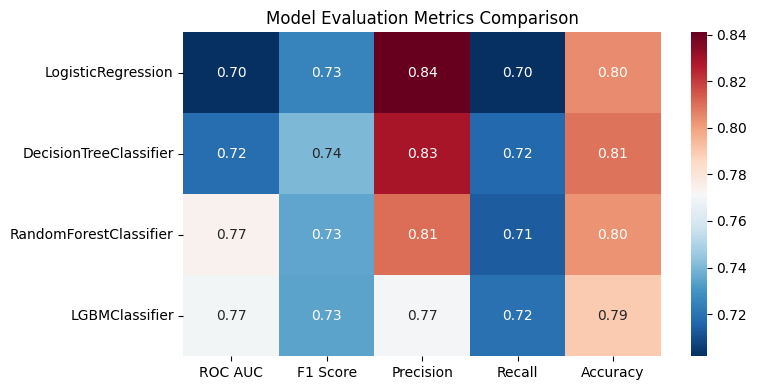

In [95]:
final_metrics = train_evaluate_models_cv(
    models=models,
    X=X_final,
    y=y,
    preprocessor=preprocessor_final,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.000761 -0.002969  -0.001345 -0.002632 -0.001626
 DecisionTreeClassifier  0.028050  0.026859   0.024052  0.022857  0.017913
 RandomForestClassifier  0.024239  0.039876   0.066263  0.033219  0.035839
 LGBMClassifier          0.021139  0.037387   0.044439  0.033833  0.030974)

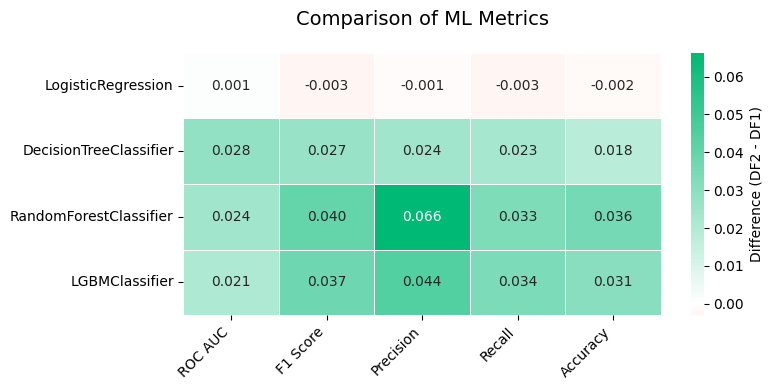

In [96]:
compare_metrics_heatmap(initial_metrics, final_metrics)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.000335 -0.002969  -0.001345 -0.002632 -0.001626
 DecisionTreeClassifier -0.002109  0.000675   0.006679 -0.000332  0.001626
 RandomForestClassifier  0.012712 -0.001411   0.016445 -0.003305  0.003239
 LGBMClassifier         -0.000090  0.007708   0.016164  0.006017  0.008077)

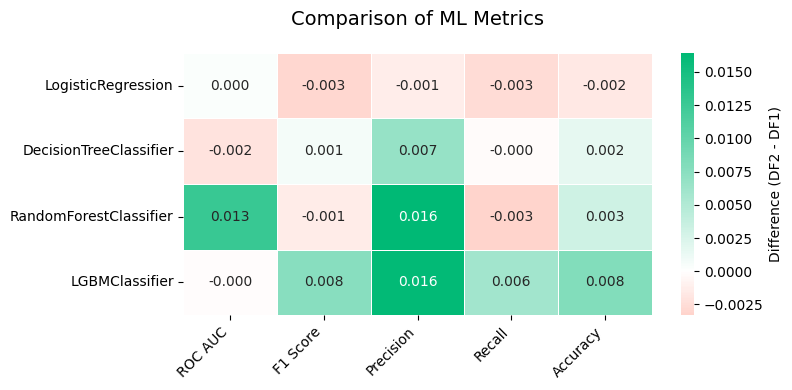

In [97]:
compare_metrics_heatmap(lir_metrics, final_metrics)